## version6 : 10/19 –

- ver5のpredictで長期予測するバージョン

### Libraries

In [115]:
import os
import sys
import math
import time
import yaml
import errno
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import trange
from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import plotly.graph_objects as go

# set random seed
fix_seed = 1111
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)

# set device 
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


### (Load a past model)

In [116]:
'''
This code is used only for loading the model and checking its prediction.
'''
# # set name of the model
# model_num = 12

# # load the model and its loss
# model = torch.load('/Users/koki/PycharmProjects/MasterThesis/models/model_' + str(model_num) + '.pth')
# loss = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='losses', usecols=[model_num-1])
# train_losses = loss.iloc[:,0].to_list()

'\nThis code is used only for loading the model and checking its prediction.\n'

### Import parameters and data

In [117]:
# load parameters
with open('/Users/koki/PycharmProjects/MasterThesis/params/config_lstm_seq2seq.yml', 'r') as yml:
    yaml_data = yaml.safe_load(yml)

In [118]:
# import data
df = pd.read_csv('/Users/koki/PycharmProjects/MasterThesis/data/preprocessed/201601to202309_10areas_for_analysis.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
# choose hours to use
time_list = yaml_data['dataset']['time_list']
if time_list != 'all':
    df = df.loc[df.index.hour.isin(time_list)]

### Define dataset

In [119]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, sequence_length=56, predict_length=8):
        self.sequence_length = sequence_length
        self.lag_length = predict_length
        self.predict_length = predict_length
        self.df = torch.tensor(dataframe.values).float()
        self.len = math.floor((len(self.df) - self.sequence_length - self.predict_length) / self.lag_length) + 1

    def __len__(self):
        return self.len

    def __getitem__(self, i):
        if type(i) == slice:
            raise Exception('Exception: Expected int, inputted slice!')
            
        X = self.df[i*self.lag_length:i*self.lag_length+self.sequence_length]
        Y = self.df[i*self.lag_length+self.sequence_length:i*self.lag_length+self.sequence_length+self.predict_length]
        
        return X, Y
    
    def input_size(self):
        return self.df.shape[1]

### Split data

In [120]:
# train
train_start = yaml_data['dataset']['train_start']
train_end = yaml_data['dataset']['train_end']

# validation
valid_start = yaml_data['dataset']['valid_start']
valid_end = yaml_data['dataset']['valid_end']

# test
test_start = yaml_data['dataset']['test_start']
test_end = yaml_data['dataset']['test_end']

# split df into train, valid and test data
df_train = df.loc[train_start:train_end].copy()
df_valid = df.loc[valid_start:valid_end].copy()
df_test = df.loc[valid_end:test_end].copy()  # テストデータの1期目を予測するために、前日もテストデータに含める。

# print the fraction of each dataset
print("Train set fraction: {:.3f}%".format(len(df_train)/len(df)*100))
print("Valid set fraction: {:.3f}%".format(len(df_valid)/len(df)*100))
print("Test set fraction: {:.3f}%".format(len(df_test)/len(df)*100))

Train set fraction: 96.749%
Valid set fraction: 12.898%
Test set fraction: 9.682%


### Set dataloader

In [121]:
batch_size = yaml_data['dataset']['batch_size']
src_length = yaml_data['dataset']['seq_len_src']
tgt_length = yaml_data['dataset']['seq_len_tgt']

# create dataset
train_dataset = SequenceDataset(df_train, sequence_length=src_length, predict_length=tgt_length)
valid_dataset = SequenceDataset(df_valid, sequence_length=src_length, predict_length=tgt_length)
test_dataset = SequenceDataset(df_test, sequence_length=src_length, predict_length=tgt_length)
print("Length of each dataset:")
print("    Train:{}, Valid:{}, Test:{}".format(len(train_dataset), len(valid_dataset), len(test_dataset)))

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0, pin_memory=True)

# check the shape of a batch
X, y = next(iter(train_loader))
print("Features shape:", X.shape)  # [batch size, sequence length, number of features]
print("Target shape:", y.shape)

Length of each dataset:
    Train:2737, Valid:364, Test:273
Features shape: torch.Size([64, 4, 66])
Target shape: torch.Size([64, 4, 66])


### Define LSTM seq2seq

In [122]:
class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, num_layers, dropout):
        
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, 
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            dropout = dropout
                           )

    def forward(self, x_input):
        
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence 
        '''
        
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        
        '''
        initialize hidden state
        : param batch_size:    x_input.shape[1]
        : return:              zeroed hidden state and cell state 
        '''
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, hidden_size, num_layers, dropout):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, 
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            dropout = dropout
                           )
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))     
        
        return output, self.hidden

    
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size, hidden_size, num_layers, dropout, batch_size, num_features_pred, training_prediction = 'recursive'):

        '''
        : param input_size:     the number of expected features in the input X
        : param hidden_size:    the number of features in the hidden state h
        '''

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout)
        
        self.batch_size= batch_size
        self.num_features_pred = num_features_pred
        self.training_prediction = training_prediction
    
    def forward(self, src, tgt):
        '''
        : param src:                       input tensor with shape (seq_len, # in batch, number features); PyTorch tensor    
        : param tgt:                       target tensor with shape (seq_len, # in batch, number features); PyTorch tensor
        : param teacher_forcing_ratio:     float [0, 1) indicating how much teacher forcing to use when
        :                                  training_prediction = 'teacher_forcing.' For each batch in training, we generate a random
        :                                  number. If the random number is less than teacher_forcing_ratio, we use teacher forcing.
        :                                  Otherwise, we predict recursively. If teacher_forcing_ratio = 1, we train only using
        :                                  teacher forcing.
        : param dynamic_tf:                use dynamic teacher forcing (True/False); dynamic teacher forcing
        :                                  reduces the amount of teacher forcing for each epoch
        '''
        # initialize hidden state
        encoder_hidden = model.encoder.init_hidden(self.batch_size)
        
        # encoder outputs
        encoder_output, encoder_hidden = self.encoder(src)

        decoder_input = src[-1, :, :]   # decoder_input.shape = [batch_size, num_features] = バッチ内の最後の1期がバッチサイズ分取られてる
        decoder_hidden = encoder_hidden
        
        seq_len_tgt = tgt.shape[0]

        # outputs tensor
        outputs = torch.zeros(seq_len_tgt, self.batch_size, src.shape[2]).to(device)
        
        if self.training_prediction == 'recursive':
            # predict recursively
            for t in range(seq_len_tgt): 
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)  # decoder_output.shape = [batch_size, num_features] 
                outputs[t] = decoder_output
                
                # decoder input at the next period = (location output from prediction) + (acurate dummy input from test data)
                decoder_input = torch.cat((decoder_output[:, 0:num_features_pred], tgt[t:t+1, :, self.num_features_pred:].squeeze()), dim=1)

        return outputs

### Define training, validation and prediction

In [123]:
def train(model, data_loader, num_features_pred, loss_calculation = 'all', teacher_forcing_ratio = 0.5, dynamic_tf = False):
    '''
    train lstm encoder-decoder
    
    : param dataloader:                input trainloader with shape (seq_len, # in batch, number of features); PyTorch tensor    
    : param num_features_pre:          number of features to be predicted 
    : param teacher_forcing_ratio:     float [0, 1) indicating how much teacher forcing to use when
    :                                  training_prediction = 'teacher_forcing.' For each batch in training, we generate a random
    :                                  number. If the random number is less than teacher_forcing_ratio, we use teacher forcing.
    :                                  Otherwise, we predict recursively. If teacher_forcing_ratio = 1, we train only using
    :                                  teacher forcing.
    : param dynamic_tf:                use dynamic teacher forcing (True/False); dynamic teacher forcing
    :                                  reduces the amount of teacher forcing for each epoch
    : return losses:                   array of loss function for each epoch
    '''
    total_loss = []
    for n_batches, (src, tgt) in enumerate(data_loader):
        src = src.to(device)
        tgt = tgt.to(device)

        # my dataset = [batch_size, seq_len, num_features]
        # model = [seq_len, batch_size, num_features]
        # So, put batch_size in the middle
        src = torch.permute(src, (1, 0, 2))
        tgt = torch.permute(tgt, (1, 0, 2))

        output = model(src=src, tgt=tgt)
        
        # zero the gradient
        optimizer.zero_grad()

        # compute the loss
        if loss_calculation == 'all':
            loss = criterion(output, tgt)
        elif loss_calculation == 'features_pred':
            loss = criterion(output[:,:,0:num_features_pred], tgt[:,:,0:num_features_pred])

        total_loss.append(loss.cpu().detach())

        # backpropagation
        loss.backward()
        optimizer.step()
    
    # return loss for epoch 
    return np.average(total_loss)


def validate(model, data_loader, num_features_pred, criterion, loss_calculation = 'all'):
    model.eval()
    total_loss = []
    for n_batches, (src, tgt) in enumerate(data_loader):
        src = src.to(device)
        tgt = tgt.to(device)

        # The shape of my dataset = [batch_size, seq_len, num_features].
        # The shape expected in this model = [seq_len, batch_size, num_features].
        # So, put batch_size in the middle.
        src = torch.permute(src, (1, 0, 2))
        tgt = torch.permute(tgt, (1, 0, 2))

        output = model(src=src, tgt=tgt)

        # compute the loss
        if loss_calculation == 'all':
            loss = criterion(output, tgt)
        elif loss_calculation == 'features_pred':
            loss = criterion(output[:,:,0:num_features_pred], tgt[:,:,0:num_features_pred])

        total_loss.append(loss.cpu().detach())
    
    # return loss for epoch 
    return np.average(total_loss)


def predict(model, test_dataset, num_features_pred):
    model.eval()
    with torch.no_grad():   
        all_outputs = torch.zeros(1, df.shape[1]).to(device)
        for t in tqdm(range(len(test_dataset))):  # (len(df_test)-8)/8 = 92回予測が必要
            src = test_dataset[t][0].float().to(device)
            tgt = test_dataset[t][1].float().to(device)
            
            # add a batch size of 1 for the encoder (= [:, 1, :])
            src = src.unsqueeze(1)  
            
            seq_len_src = src.shape[0]
            seq_len_tgt = tgt.shape[0]

            encoder_output, encoder_hidden = model.encoder(src)

            # initialize tensor for predictions
            outputs = torch.zeros(seq_len_tgt, tgt.shape[1]).to(device)  # outputs.shape =  [seq_len, num of features]

            # decode input_tensor
            decoder_input = src[-1, :, :]
            decoder_hidden = encoder_hidden

            for t in range(seq_len_tgt):
                decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)  # decoder_output.shape = [1(seq_len), num_features]
                outputs[t] = decoder_output
                # decoder input at the next period = (location output from prediction) + (acurate dummy input from test data)
                decoder_input = torch.cat((decoder_output[:, 0:num_features_pred], tgt[t:t+1, num_features_pred:]), dim=1)
      
            all_outputs = torch.cat([all_outputs, outputs], dim=0)
        
    return all_outputs[1:, :num_features_pred]

### Define parameters

In [124]:
input_size = df.shape[1]
hidden_size = yaml_data['model']['hidden_size']
num_layers = yaml_data['model']['num_layers']
dropout = yaml_data['model']['dropout']
num_features_pred = yaml_data['training']['num_features_pred']
training_prediction = yaml_data['training']['training_prediction']
teacher_forcing_ratio= yaml_data['training']['teacher_forcing_ratio']
dynamic_tf = yaml_data['training']['dynamic_tf']
n_epochs = yaml_data['training']['n_epochs']
loss_calculation = yaml_data['training']['loss_calculation']
learning_rate = yaml_data['training']['learning_rate']
best_loss = float('Inf')
best_model = None

model = lstm_seq2seq(input_size = input_size, 
                     hidden_size = hidden_size, 
                     num_layers = num_layers, 
                     dropout = dropout,
                     batch_size=batch_size, 
                     num_features_pred=num_features_pred, 
                     training_prediction = 'recursive').to(device)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss().to(device)

### Training

In [125]:
start = time.time()

train_losses = []
valid_losses = []
with trange(n_epochs) as tr:
    for it in tr:
        # train
        loss_train = train(model=model, 
                     data_loader=train_loader, 
                     num_features_pred=num_features_pred, 
                     loss_calculation = loss_calculation)  
        # validation
        loss_valid = validate(model=model, 
                              data_loader=valid_loader, 
                              num_features_pred=num_features_pred, 
                              criterion=criterion, 
                              loss_calculation=loss_calculation)
        
        # convert to RMSE
        loss_train = math.sqrt(loss_train)
        loss_valid = math.sqrt(loss_valid)
        
        train_losses.append(loss_train)
        valid_losses.append(loss_valid)
        
        # record the best loss and the model 
        if best_loss > loss_valid:
            best_loss = loss_valid
            best_model = model

        # progress bar 
        tr.set_postfix({"Train_loss":"{:.3f}".format(loss_train), "Valid_loss":"{:.3f}".format(loss_valid)})

end = time.time()
t = math.floor(end-start)

elapsed_hour = t // 3600
elapsed_minute = (t % 3600) // 60
elapsed_second = (t % 3600 % 60)

elapsed_time = str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2)

100%|██████████████████████████████████████████████| 2000/2000 [25:41<00:00,  1.30it/s, Train_loss=16186.785, Valid_loss=12765.982]


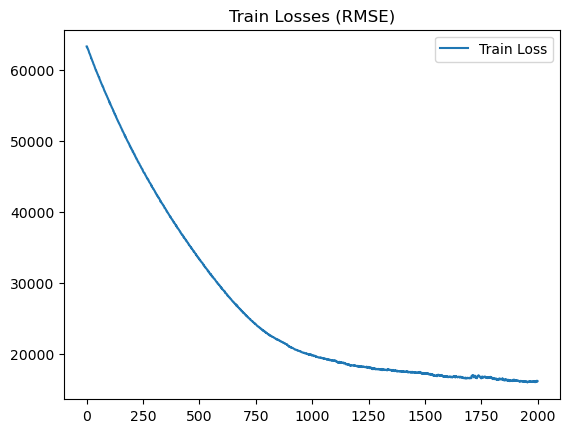

In [126]:
plt.plot(train_losses, label='Train Loss')
plt.title('Train Losses (RMSE)')
plt.legend()
plt.show()

### Predict

In [145]:
# make y_true df
y_true = df_test.iloc[tgt_length:, 0:num_features_pred]

# make y_pred df
pred = predict(model=model, test_dataset = test_dataset, num_features_pred = num_features_pred).cpu()
y_pred = pd.DataFrame(pred, columns=df.columns[0:num_features_pred], index=y_true.index).add_prefix('pred_')

  0%|          | 0/273 [00:00<?, ?it/s]

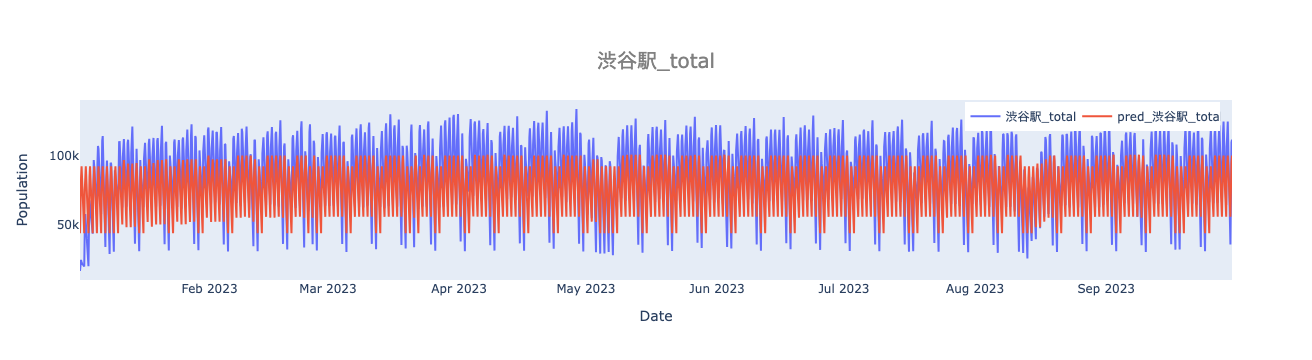

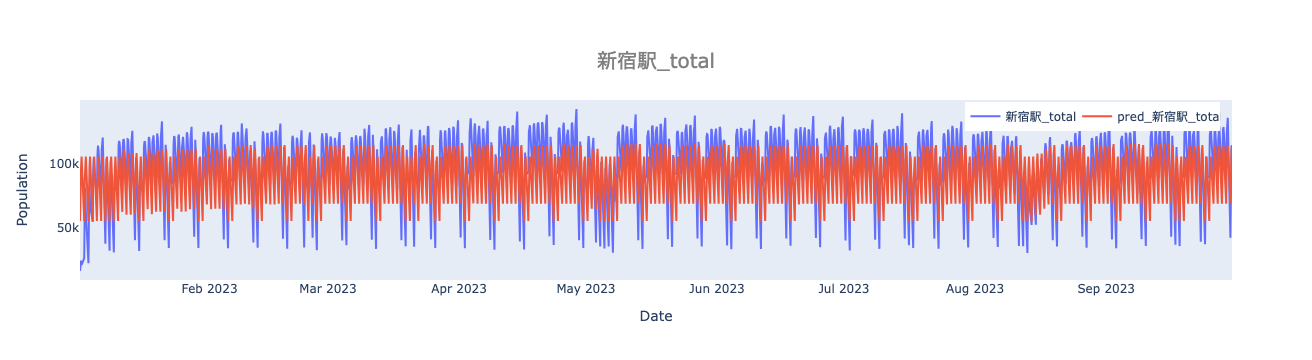

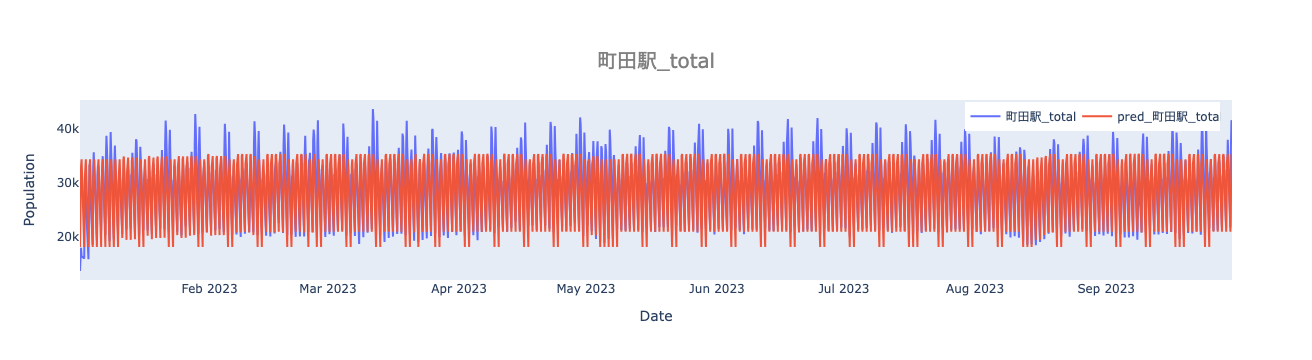

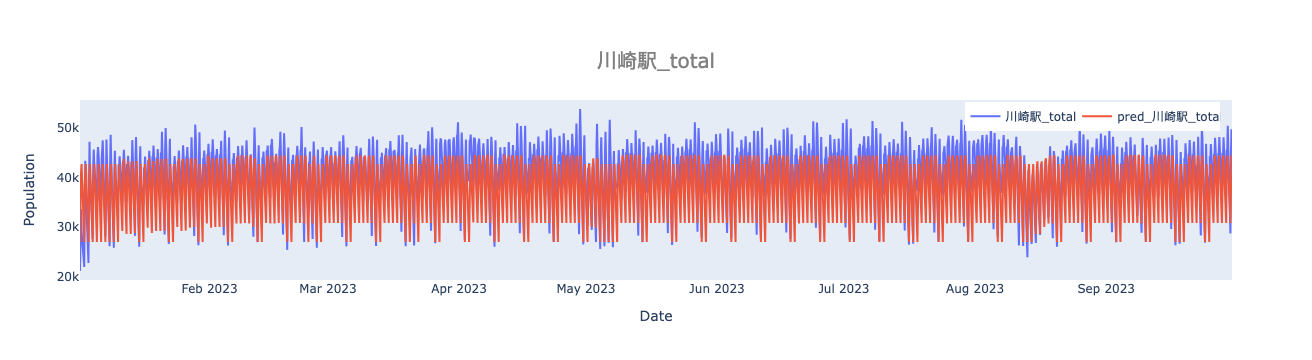

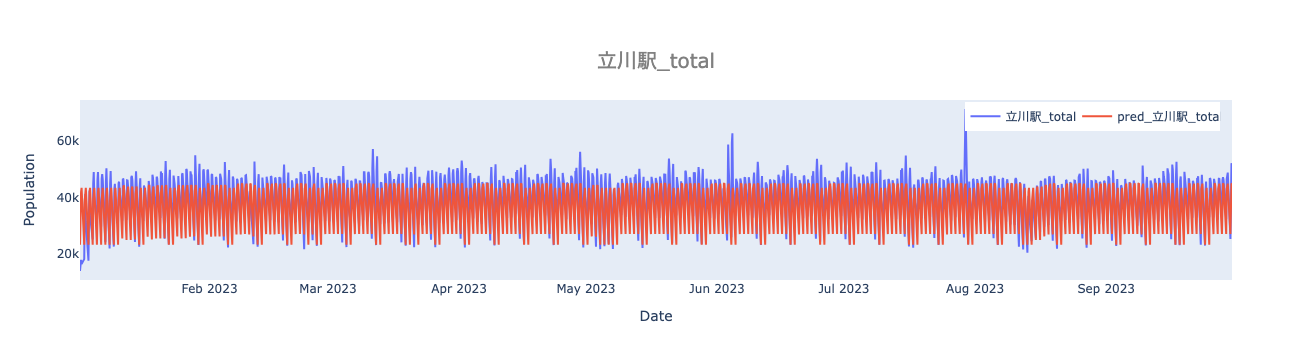

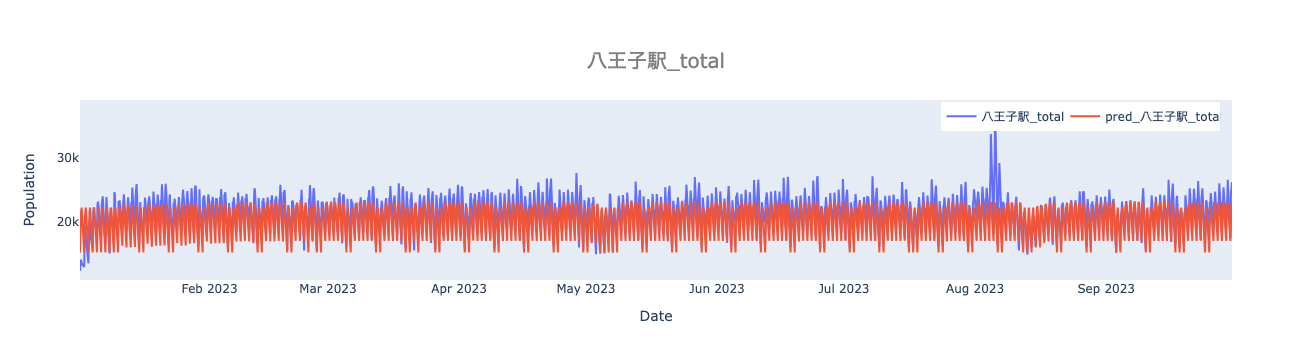

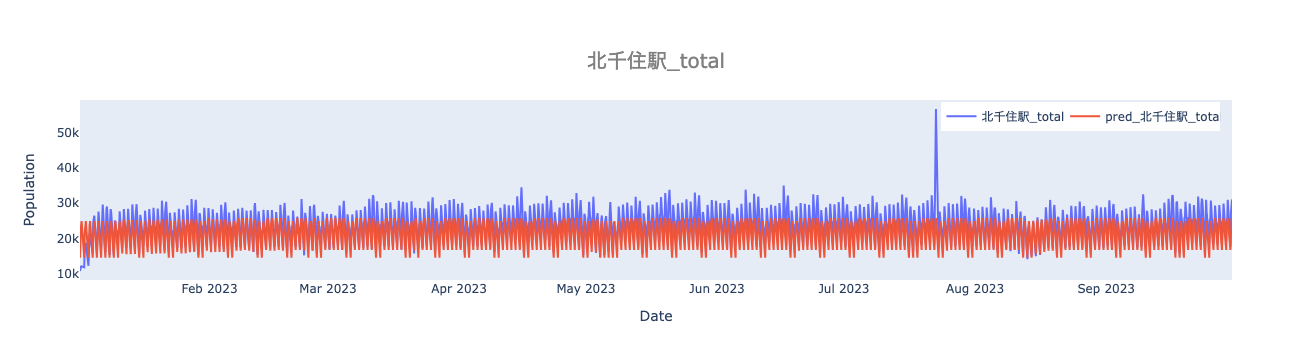

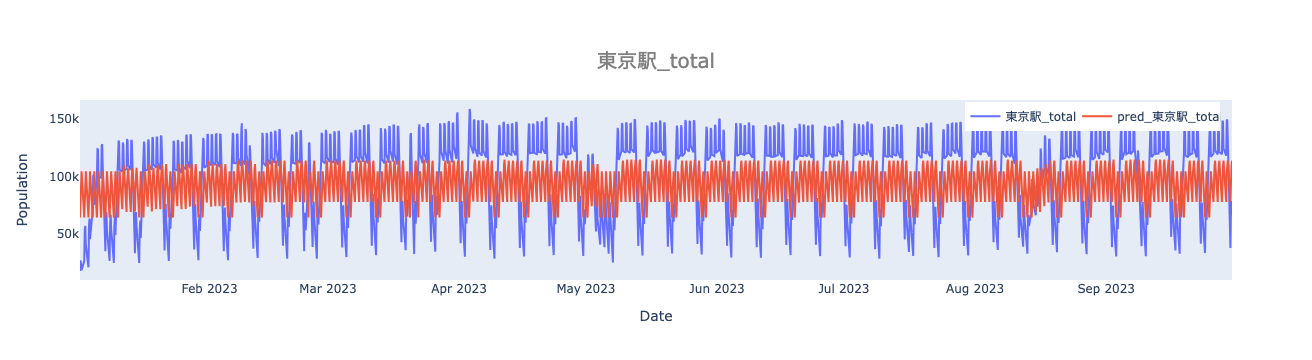

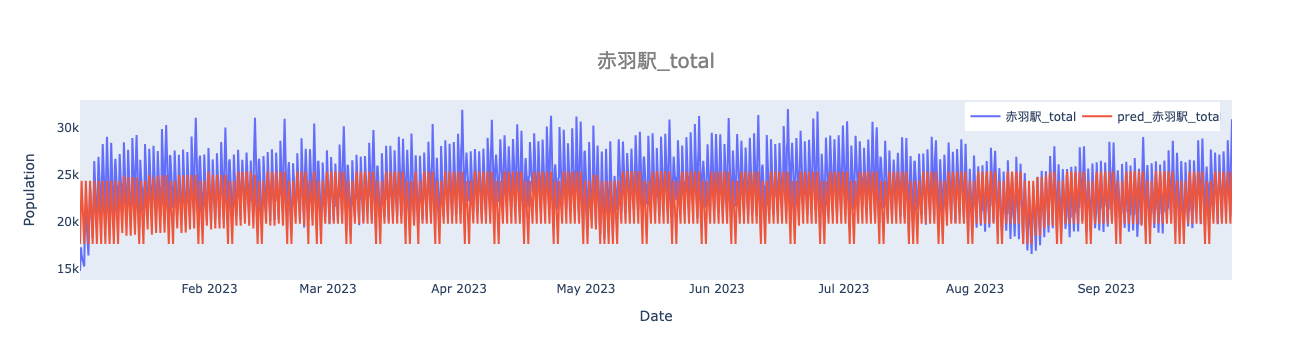

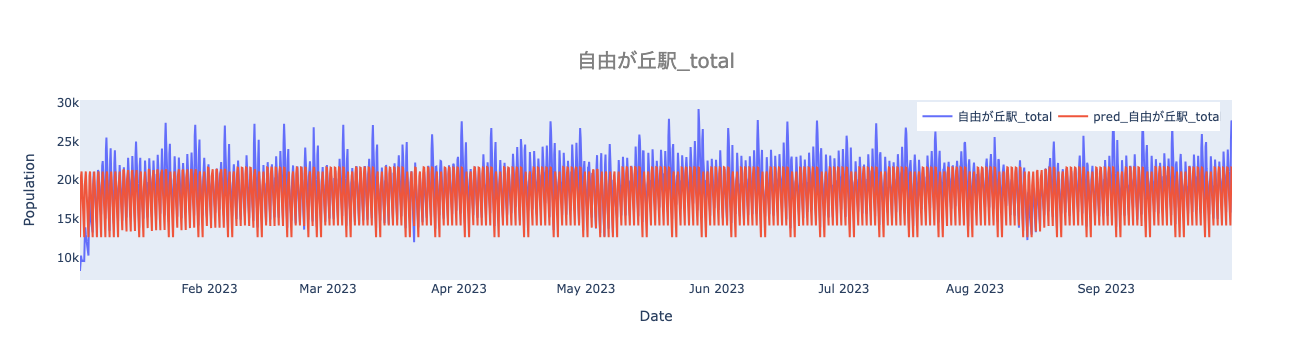

In [147]:
# plot with plotly     
for i in range(y_pred.shape[1]):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_true.index, y=y_true.iloc[:, i], name=y_true.columns[i]))
    fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred.iloc[:, i], name=y_pred.columns[i]))
    fig.update_xaxes(title="Date",showgrid=False)
    fig.update_yaxes(title="Population", showgrid=False)
    fig.update_layout(legend=dict(x=0.99,
                              y=0.99,
                              xanchor='right',
                              yanchor='top',
                              orientation='h',
                              ),
                      hovermode='x unified',
                      title=dict(text=y_true.columns[i],
                                 font=dict(size=20, color='grey'),
                                 xref='paper', # container or paper
                                 x=0.5,
                                 y=0.85,
                                 xanchor='center'
                                )
                     )
    fig.show()

### Calculate MSE and MAE by actual values

In [148]:
print('------------MSE------------')
mse = []
for i in range(y_true.shape[1]):
    mse.append(mean_squared_error(y_true.iloc[:,i], y_pred.iloc[:,i], squared=False))
    print(y_true.columns[i], ':', mse[i])
print('Average :', np.mean(mse))
    
print('------------MAE------------')
mae= []
for i in range(y_true.shape[1]):
    mae.append(mean_absolute_error(y_true.iloc[:,i], y_pred.iloc[:,i]))
    print(y_true.columns[i], ':', mae[i])
print('Average :', np.mean(mae))

------------MSE------------
渋谷駅_total : 18331.050668301097
新宿駅_total : 19262.599318648565
町田駅_total : 3054.705720980535
川崎駅_total : 4154.95091562925
立川駅_total : 4988.611836684091
八王子駅_total : 1847.511890841003
北千住駅_total : 3167.5658828491005
東京駅_total : 35763.96134264353
赤羽駅_total : 2421.2066551503913
自由が丘駅_total : 2286.2071980346645
Average : 9527.837142976223
------------MAE------------
渋谷駅_total : 16372.547179057921
新宿駅_total : 17109.733194539836
町田駅_total : 2378.590086996337
川崎駅_total : 3431.1785767942993
立川駅_total : 3949.924600789835
八王子駅_total : 1442.270547161172
北千住駅_total : 2441.255400605254
東京駅_total : 32842.073463970926
赤羽駅_total : 1999.324687356914
自由が丘駅_total : 1771.1663509830014
Average : 8373.806408825549


### Calculate RMSE and MAE by benchmark

In [149]:
# test_dataの直近4週間のデータを抽出
df_bench = df_valid.iloc[-28*tgt_length:,:]

bench = pd.DataFrame()
dow = ['dow_Mon','dow_Tue','dow_Wed','dow_Thu','dow_Fri','dow_Sat', 'dow_Sun']
for d in dow:
    # 各曜日ダミーが1であるデータを抽出し、その合計を取る
    bench[d] = df_bench[df_bench[d]==1].iloc[:, :num_features_pred].mean()

In [150]:
bench

dow_Mon      dow_Tue      dow_Wed      dow_Thu      dow_Fri  \
渋谷駅_total     98717.0625   98066.2500   99203.1250   95299.3125   94854.2500   
新宿駅_total    110083.9375  109321.1250  108964.4375  104520.8750  103232.3125   
町田駅_total     29523.3125   29428.1875   29971.5625   30655.1875   31337.1250   
川崎駅_total     42042.6250   41844.8750   43066.4375   41553.8750   41876.0000   
立川駅_total     42899.0000   42660.7500   43708.8750   43007.8750   43497.5625   
八王子駅_total    22276.2500   21940.5000   22305.0000   22224.8750   22408.9375   
北千住駅_total    23888.6875   23953.2500   23851.8125   24439.5000   24944.1875   
東京駅_total    119075.1250  117857.1250  117437.5000  112457.5000  111663.2500   
赤羽駅_total     23996.8125   23974.3750   24118.6250   24285.5625   24356.1250   
自由が丘駅_total   20054.6250   19784.5625   19898.7500   20200.5000   20148.0000   

                dow_Sat     dow_Sun  
渋谷駅_total    79247.0625  83223.9375  
新宿駅_total    80668.8750  79745.3125  
町田駅_total    32622.5625  33133.9375  
川崎駅_total    40487.5000  40813.3125  
立川駅_total    41118.0000  41897.5625  
八王子駅_total   21842.6250  21558.6875  
北千住駅_total   24710.7500  23985.5000  
東京駅_total    61470.3750  60433.1250  
赤羽駅_total    24854.1250  24031.7500  
自由が丘駅_total  20678.5625  20948.3125

In [151]:





# calculate RMSE (y_true = the mean of the past one month, y_pred = the mean of all the predicted values)
dow = ['dow_Mon','dow_Tue','dow_Wed','dow_Thu','dow_Fri','dow_Sat', 'dow_Sun']
d = dow[y_pred.index[0].weekday()]
bench = mean_absolute_error(_df[_df[d]==1].mean()[:num_features_pred], y_pred.iloc[:,:num_features_pred].mean())
print(d, 'RMSE: ', mean_squared_error(_df[_df[d]==1].mean()[:num_features_pred], y_pred.iloc[:,:num_features_pred].mean(), squared=False))
print(d, 'MAE: ', bench)
print('absolute_error')
for i in range(y_true.shape[1]):
    print(f'   {y_true.columns[i]}: {np.abs(_df[_df[d]==1].mean()[:num_features_pred][i] - y_pred.iloc[:,:num_features_pred].mean()[i])}')

dow_Sun RMSE:  8414.817177498713
dow_Sun MAE:  5870.198320312501
absolute_error
   渋谷駅_total: 14681.1484375
   新宿駅_total: 11326.5078125
   町田駅_total: 759.990234375
   川崎駅_total: 2478.128125000003
   立川駅_total: 4513.3984375
   八王子駅_total: 1785.4074218749993
   北千住駅_total: 2596.75
   東京駅_total: 17993.846875000003
   赤羽駅_total: 1577.1300781249993
   自由が丘駅_total: 989.67578125


In [152]:
bench = 0

### Save the results and the model 

In [153]:
'''
save the model, its loss, and params used
'''
# count the number of files in the directory
path = '/Users/koki/PycharmProjects/MasterThesis/models'

# read parameter data
df1 = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='params')

# set a model name
num = 'model_' + str(df1.shape[0]+1).zfill(2)

# get params used in this file
series = pd.concat([pd.Series(yaml_data['dataset']), pd.Series(yaml_data['model']), pd.Series(yaml_data['training'])])
params = pd.DataFrame(series).T
params.insert(0, "num", num)
params.insert(1, "file_name", "LSTM_seq2seq_ver6")  ###### the name of this file! ######
params.insert(2, "date_of_execution", datetime.datetime.today().strftime("%Y-%m-%d %H:%M"))
params.insert(3, "execution_time", elapsed_time)
params.insert(params.shape[1], "final_train_loss" , math.floor(train_losses[-1]))
params.insert(params.shape[1], "final_valid_loss" , math.floor(valid_losses[-1]))
params.insert(params.shape[1], "mse_observation" , math.floor(np.mean(mse)))
params.insert(params.shape[1], "mae_observation" , math.floor(np.mean(mae)))
params.insert(params.shape[1], "mae_benchmark" , math.floor(bench))
df1 = pd.concat([df1, params])

# read loss data
df2 = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='train_losses')
df2 = pd.concat([df2, pd.Series(train_losses, name=num)], axis=1)

# read valid loss data
df3 = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='valid_losses')
df3 = pd.concat([df3, pd.Series(valid_losses, name=num)], axis=1)

# export the data 
with pd.ExcelWriter('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx') as writer:
    df1.to_excel(writer, sheet_name='params', index=False)
    df2.to_excel(writer, sheet_name='train_losses', index=False)
    df3.to_excel(writer, sheet_name='valid_losses', index=False)

# save the model
torch.save(model, '/Users/koki/PycharmProjects/MasterThesis/models/' + num + '.pth')

In [154]:
# notification
# !afplay '/Users/koki/Documents/セレナと一緒/result_message.m4a'

In [19]:
print('Done!')

Done!


### Memo

In [20]:
'''
再帰的に予測する際、t+1期のインプットには、t期の人流のアウトプット（t+1期の人流の予測値）＋t+1期の実際のダミー情報（t期からアウトプットされた予測ではなく本当のデータ）を利用する。
    →例えば曜日などは予測しなくてもわかるはずなので、わざわざ再帰的に予測値をインプットする必要がない
'''

'\n再帰的に予測する際、t+1期のインプットには、t期の人流のアウトプット（t+1期の人流の予測値）＋t+1期の実際のダミー情報（t期からアウトプットされた予測ではなく本当のデータ）を利用する。\n    →例えば曜日などは予測しなくてもわかるはずなので、わざわざ再帰的に予測値をインプットする必要がない\n'

### Questions

In [ ]:
'''
seq2seqの学習時のdecoderはどうするの？再起的にループさせるの？
'''

### Insight

In [21]:
'''
num_layersよりhidden_sizeを増やした方が精度が良い →　(num_layers=2, hidden_size=128) > (num_layers=3, hidden_size=64)
'''

'\nnum_layersよりhidden_sizeを増やした方が精度が良い →\u3000(num_layers=2, hidden_size=128) > (num_layers=3, hidden_size=64)\n'

### To Do

In [22]:
'''
'''

'\n'